## Многомерная линейная регрессия

До этого мы рассматривали только один признак - среднее число комнат на участке. Давайте в нашу модель добавим еще один признак - процент жителей с низким социальным статусом (`LSTAT`).

In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt
plt.style.use("seaborn")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
from sklearn.datasets import load_boston
boston = load_boston()

In [5]:
data = pd.DataFrame(data=boston.data, columns=boston.feature_names)
data["MEDV"] = boston.target
data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


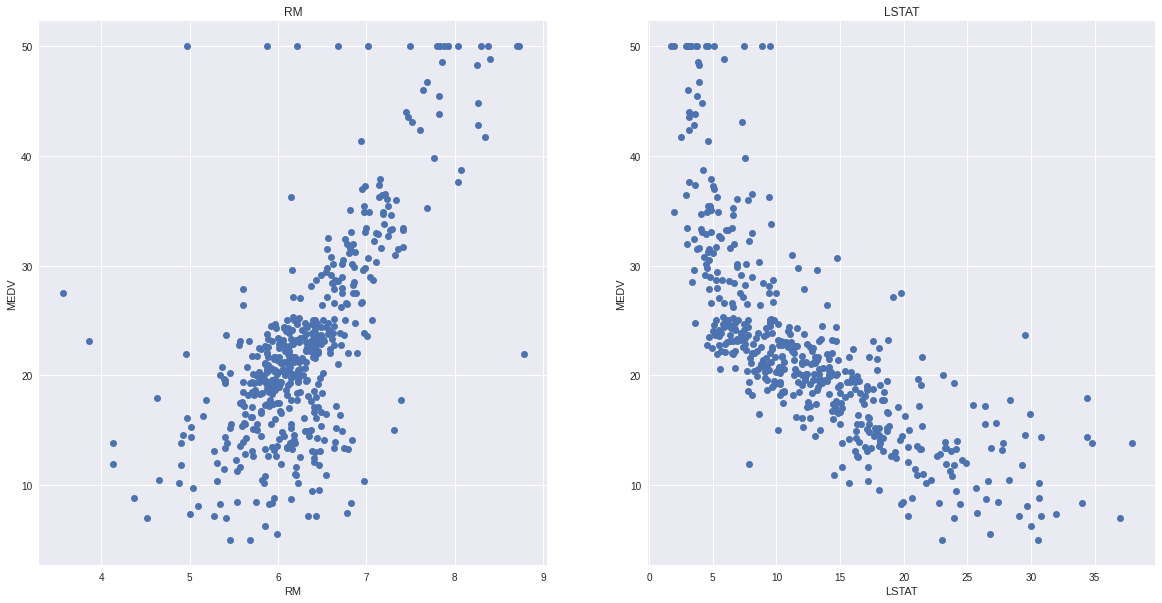

In [6]:
plt.figure(figsize=(20, 10))
for i, col in enumerate(["RM", "LSTAT"]):
    plt.subplot(1, 2, (i+1))
    plt.plot(data[col], data["MEDV"], 'o')
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('MEDV')

In [15]:
X_filtered = data[(data["MEDV"] < 50)][["RM", "LSTAT"]]
y_filtered = data[(data["MEDV"] < 50)][["MEDV"]]

In [16]:
def z_scaler(feature):
    col = feature.columns
    for i in range(len(col)):
        sum_sd = 0
        mean_sd = sum(feature[col[i]].values) / len(feature[col[i]].values)
        scaled = []
        for j in range(len(feature[col[i]].values)):
            sum_sd += (feature[col[i]].values[j] - mean_sd)**2
        sd = sqrt(sum_sd / (len(feature[col[i]].values) - 1))
        for j in range(len(feature[col[i]].values)):
            scaled.append((feature[col[i]].values[j] - mean_sd) / sd)
    return pd.DataFrame(scaled)

In [17]:
X_scaled = z_scaler(X_filtered)
y_scaled = z_scaler(y_filtered)

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso

In [20]:

class GDRegressor:

    def __init__(self, alpha=0.01, n_iter=100, progress=True):
        self.alpha = alpha
        self.n_iter = n_iter
        self.disable = not progress

    def fit(self, X, y):
        self.coef_ = []
        attributes = [X.values]
        theta = [[]]
        self.loss_history = []
        for i in range(len(attributes)):
            self.coef_.append(0)
            theta.append([])
        self.intercept_ = 0
        for i in range(self.n_iter):
            error = 0
            error_coef = 0
            for k in range(len(attributes)):
                n = len(attributes[k])
                for j in range(n):
                    y_predicted = self.coef_[k] * attributes[k][j] + self.intercept_
                    error +=  (y.values[j] - y_predicted)
                    error_coef += (y.values[j] - y_predicted) * attributes[k][j]
                self.d_coef = - (1 / n) * error_coef
                self.coef_[k] = self.coef_[k] - self.alpha * self.d_coef
                theta[k+1].extend(self.coef_)
            self.d_intercept = - (1 / n) * error
            self.intercept_ = self.intercept_ - self.alpha * self.d_intercept
            theta[0].extend(self.intercept_)
            self.loss_history.extend(error)
        self.theta_history = pd.DataFrame({'0':theta[0]})
        for i in range(len(attributes)):
            self.theta_history[1] = theta[i + 1]
        return self.coef_, self.intercept_
            

    def predict(self, X_test):
        attributes = [X_test.values]
        self.y_predict = []
        for i in range(len(attributes[0])):
            y_curr = 0
            for j in range(len(attributes)):
                y_curr += attributes[j][i] * self.coef_[j] 
            self.y_predict.extend(y_curr + self.intercept_)
        return self.y_predict
    
    def lasso(self, X, y):
        lasso = Lasso(max_iter=2500)
        parametres = {'alpha':[1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1, 5, 10, 20]}
        self.lasso_regressor = GridSearchCV(lasso, parametres, scoring='neg_mean_squared_error', cv=5)
        self.lasso_regressor.fit(X_1_filtered, y_1_filtered)
        return self.lasso_regressor.best_params_, self.lasso_regressor.best_score_

In [21]:
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, y_scaled, test_size=0.33, random_state=18)
model = GDRegressor(alpha=0.01, n_iter=300)
%time model.fit(X_train, Y_train)

CPU times: user 2.36 s, sys: 0 ns, total: 2.36 s
Wall time: 2.36 s


([array([-0.71013897])], array([-0.04284463]))

In [22]:
def plot_loss_function(model):
    plt.xlabel("Iterations")
    plt.ylabel("Average square loss")
    plt.plot(np.arange(model.n_iter), model.loss_history);

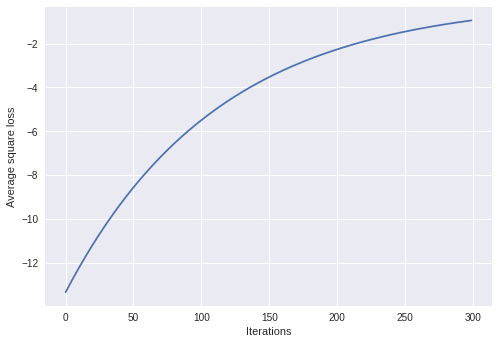

In [23]:
plot_loss_function(model)

In [24]:
def rmse(y_hat, y):
    sum_ = 0
    for i in range(len(y)):
        sum_ += (y_hat[i] - y.values[i])**2
    return sqrt(sum_ / len(y))

In [25]:

def r_squared(y_hat, y):
    y_mean = sum(y.values)/len(y.values)
    sum_mean = 0
    sum_ = 0
    for i in range(len(y)):
        sum_ += (y.values[i] - y_hat[i])**2
        sum_mean += (y.values[i] - y_mean)**2
    return (1 - sum_ / sum_mean)

In [27]:
Y_pred = model.predict(X_test)
rmse(Y_pred, Y_test), r_squared(Y_pred, Y_test)

(0.6829680366478612, array([0.59588588]))

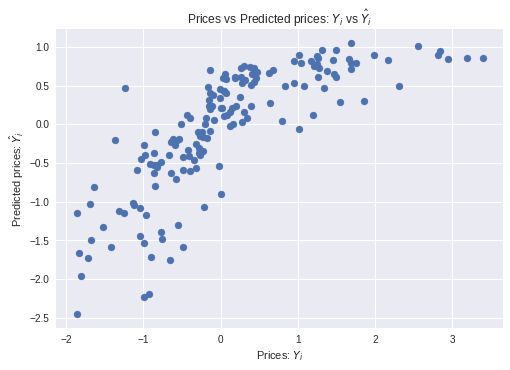

In [28]:
plt.scatter(Y_test, Y_pred)
plt.xlabel("Prices: $Y_i$")
plt.ylabel("Predicted prices: $\hat{Y}_i$")
plt.title("Prices vs Predicted prices: $Y_i$ vs $\hat{Y}_i$");

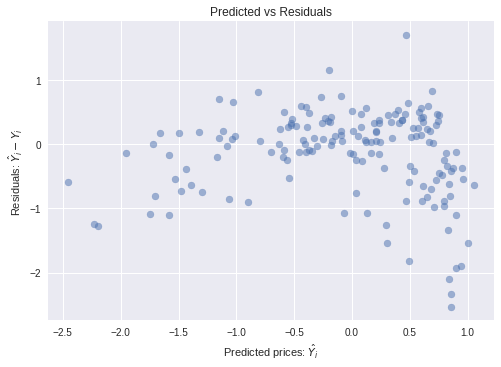

In [30]:
plt.xlabel("Predicted prices: $\hat{Y}_i$")
plt.ylabel("Residuals: $\hat{Y}_i - Y_i$")
plt.title("Predicted vs Residuals");
plt.scatter(Y_pred, (Y_pred - np.ravel(Y_test)), alpha=0.5);

Из графика хорошо видно, что есть нелинейная зависимость в остатках. Это связано с тем, что процент жителей с низким социальным статусом нелинейно зависит от средней цены на дом и среднего числа комнат:

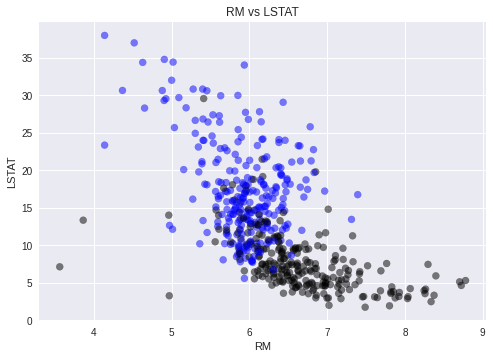

In [31]:
colors = ['k' if v > data["MEDV"].median() else 'b' for v in data["MEDV"]]
plt.scatter(data["RM"], data["LSTAT"], c=colors, alpha=0.5)
plt.xlabel("RM");
plt.ylabel("LSTAT");
plt.title("RM vs LSTAT")
plt.show()

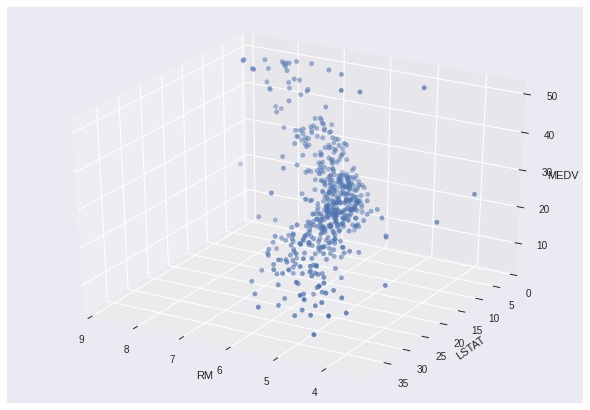

In [32]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()#figsize=(15, 10))
ax = Axes3D(fig)
ax.set_xlabel('RM')
ax.set_ylabel('LSTAT')
ax.set_zlabel('MEDV');
ax.view_init(azim=120)
ax.scatter3D(data["RM"], data["LSTAT"], data["MEDV"])
plt.show()

Эту зависимость наша модель в настоящий момент не описывает. Таким образом, мы должны добавить в нашу модель нелинейные признаки.

### Добавление полиномиальных признаков

Итак, для описания нелинейной зависимости мы будем использовать полиномиальную модель. Предположим, что полинома четвертой степени достаточно для описания зависимости. Возможно будет достаточно полинома второй или третьей степени, поэтому, чтобы «занулить» некоторые коэффициенты $\theta$, мы будем использовать L1-регуляризацию.

In [34]:
from sklearn.preprocessing import PolynomialFeatures

In [35]:
poly = PolynomialFeatures(4, include_bias=False)
X_filtered_poly = poly.fit_transform(X_filtered)

In [37]:
X_train, X_test, Y_train, Y_test =\
    train_test_split(X_filtered_poly, y_filtered, test_size = 0.33, random_state = 18)
x_scaler = StandardScaler()
y_scaler = StandardScaler()
X_train = x_scaler.fit_transform(X_train)
Y_train = y_scaler.fit_transform(Y_train.values.reshape(-1, 1))
X_test = x_scaler.transform(X_test)
Y_test = y_scaler.transform(Y_test.values.reshape(-1, 1))

In [38]:
model = SGDRegressor(
    loss='squared_loss',
    penalty='l1',
    alpha=0.01,
    learning_rate='constant',
    max_iter=1000,
    eta0=0.005
)
model.fit(X_train, Y_train.ravel())

SGDRegressor(alpha=0.01, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.005, fit_intercept=True, l1_ratio=0.15,
             learning_rate='constant', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty='l1', power_t=0.25, random_state=None,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [39]:
Y_pred = model.predict(X_test)

In [40]:
mean_squared_error(Y_test, Y_pred), r2_score(Y_test, Y_pred)

(0.2251730960044262, 0.8213502223161422)

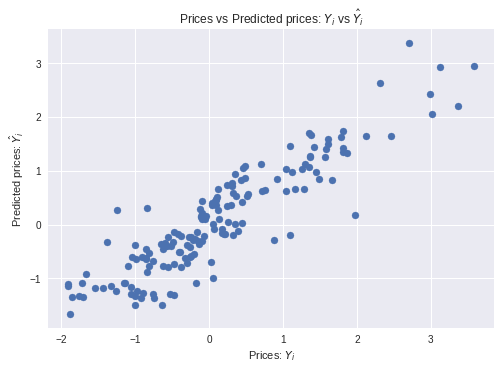

In [41]:
plt.scatter(Y_test, Y_pred)
plt.xlabel("Prices: $Y_i$")
plt.ylabel("Predicted prices: $\hat{Y}_i$")
plt.title("Prices vs Predicted prices: $Y_i$ vs $\hat{Y}_i$");

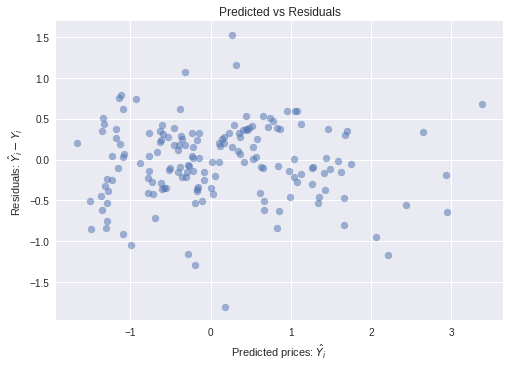

In [42]:
fig = plt.figure()
plt.scatter(Y_pred, (Y_pred-Y_test.reshape(1, -1)), alpha=0.5);
plt.xlabel("Predicted prices: $\hat{Y}_i$")
plt.ylabel("Residuals: $\hat{Y}_i - Y_i$")
plt.title("Predicted vs Residuals");
fig.savefig('lr_residuals3.png', dpi=fig.dpi)

In [43]:
model.coef_, model.intercept_

(array([ 0.        ,  0.        ,  0.13272508, -0.09088749,  0.        ,
         0.21946145, -0.20273277,  0.        ,  0.        ,  0.24734024,
        -0.26318092, -0.02131917,  0.        ,  0.08833166]),
 array([0.01581092]))

In [44]:
poly.get_feature_names(X_filtered.columns)

['RM',
 'LSTAT',
 'RM^2',
 'RM LSTAT',
 'LSTAT^2',
 'RM^3',
 'RM^2 LSTAT',
 'RM LSTAT^2',
 'LSTAT^3',
 'RM^4',
 'RM^3 LSTAT',
 'RM^2 LSTAT^2',
 'RM LSTAT^3',
 'LSTAT^4']

### Задания

- Постройте кривые обучения
- Какие еще признаки, кроме `LSTAT`, могут улучшить нашу модель? Отберите лучшие, ориентируйтесь на кривые обучения, а также проверяйте ваши модели на валидационных данных.
- Добавьте L2 (Lasso) регуляризацию в класс `GDRegressor`

Постройте кривые обучения

In [45]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import learning_curve

def learning_curves(estimator, features, target, train_sizes, cv):
    
    train_sizes, train_scores, validation_scores = learning_curve(
    estimator, features, target, train_sizes = train_sizes,
    cv = cv, scoring = 'neg_mean_squared_error')
    train_scores_mean = -train_scores.mean(axis = 1)
    validation_scores_mean = -validation_scores.mean(axis = 1)

    plt.plot(train_sizes, train_scores_mean, label = 'Training error')
    plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')

    plt.ylabel('MSE', fontsize = 14)
    plt.xlabel('Training set size', fontsize = 14)
    title = 'Learning curves for a ' + str(estimator).split('(')[0] + ' model'
    plt.title(title, fontsize = 18, y = 1.03)
    plt.legend()
    plt.ylim(0,170)

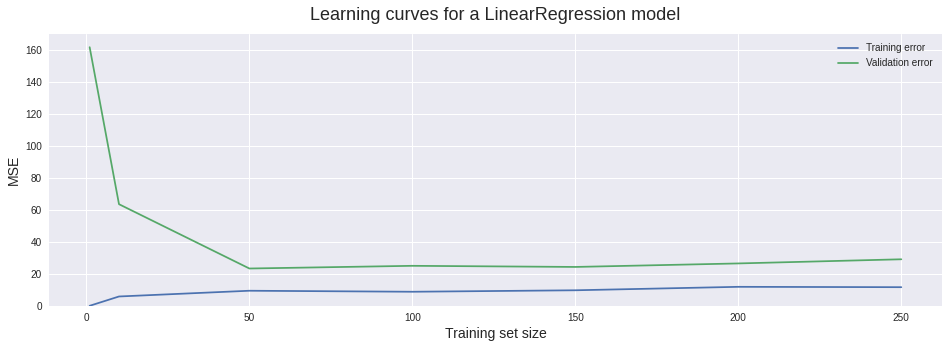

In [46]:
plt.figure(figsize = (16,5))
train_sizes = [1, 10, 50, 100, 150, 200, 250]

learning_curves(LinearRegression(), X_filtered, y_filtered, train_sizes, 5)

Какие еще признаки, кроме LSTAT, могут улучшить нашу модель? Отберите лучшие, ориентируйтесь на кривые обучения, а также проверяйте ваши модели на валидационных данных.

In [47]:
X_1_filtered = data[(data["MEDV"] < 50)][["RM", "LSTAT", "PTRATIO", "ZN"]]
y_1_filtered = data[(data["MEDV"] < 50)][["MEDV"]]

In [48]:
X_1_scaled = z_scaler(X_filtered)
y_1_scaled = z_scaler(y_filtered)

In [49]:
X_1_filtered_poly = poly.fit_transform(X_1_filtered)

In [50]:
X_1_train, X_1_test, Y_1_train, Y_1_test =\
    train_test_split(X_1_filtered_poly, y_1_filtered, test_size = 0.33, random_state = 18)
x_1_scaler = StandardScaler()
y_1_scaler = StandardScaler()
X_1_train = x_1_scaler.fit_transform(X_1_train)
Y_1_train = y_1_scaler.fit_transform(Y_1_train.values.reshape(-1, 1))
X_1_test = x_1_scaler.transform(X_1_test)
Y_1_test = y_1_scaler.transform(Y_1_test.values.reshape(-1, 1))

In [51]:
model.fit(X_1_train, Y_1_train.ravel())

SGDRegressor(alpha=0.01, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.005, fit_intercept=True, l1_ratio=0.15,
             learning_rate='constant', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty='l1', power_t=0.25, random_state=None,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [52]:
Y_1_pred = model.predict(X_1_test)

In [53]:
mean_squared_error(Y_1_test, Y_1_pred), r2_score(Y_1_test, Y_1_pred)

(0.1985722600042028, 0.8424550235644728)

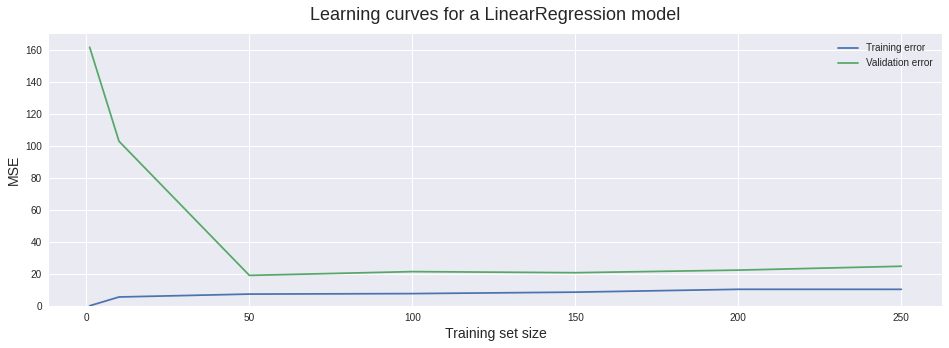

In [54]:
plt.figure(figsize = (16,5))
train_sizes = [1, 10, 50, 100, 150, 200, 250]

learning_curves(LinearRegression(), X_1_filtered, y_1_filtered, train_sizes, 5)

Добавьте L2 (Lasso) регуляризацию в класс GDRegressor

In [55]:
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, y_scaled, test_size=0.33, random_state=18)
model = GDRegressor(alpha=0.01, n_iter=300)
%time model.fit(X_train, Y_train)

CPU times: user 2.34 s, sys: 1.89 ms, total: 2.34 s
Wall time: 2.35 s


([array([-0.71013897])], array([-0.04284463]))

In [56]:
model.lasso(X_train, Y_train)

({'alpha': 1e-08}, -24.34277361355671)